## Model Building in XGBoost

This is a great article for tunning XGboost: http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [57]:
import os
windows=False
if (windows):
    mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
    os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import time
import csv
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [67]:
use_validation=True
scale_numericals=False

In [68]:
#now we load our modified train and test set
tic()
sufix=""
if (use_validation): sufix += "_holdout"
if (scale_numericals): sufix += "_scaled"
print ("sufix: "+sufix)

dtrain = pd.read_csv("./input-data/train_modified"+sufix+".csv",
                    dtype = {'Canal_ID': 'int8',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'int8',
                            'prodtype_cluster': 'int8',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8',
                            'Cliente_ID_clust_ID':'int8'},
                   )
                  
dval = pd.read_csv("./input-data/val_modified"+sufix+".csv",
                    dtype = {'Canal_ID': 'int8',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'int8',
                            'prodtype_cluster': 'int8',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8',
                            'Cliente_ID_clust_ID':'int8'},
                   ) 
    
dtest = pd.read_csv("./input-data/test_modified"+sufix+".csv",
                    dtype = {'id': 'uint32',
                            'Canal_ID': 'int8',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'int8',
                            'prodtype_cluster': 'int8',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8',
                            'Cliente_ID_clust_ID':'int8'},
                      )
tac()

sufix: _holdout
Time passed: 0hour:0min:49sec


In [69]:
#Define target and ID columns:
target = 'log_target'
IDcol = 'id'

Ok, so we said on our prior step (Models wiht scikit-learn) that we need to treat outliers. Let's do this first.

Looking at the plot below, created on the clustering-by-demand on the feature engineering notebook, we are going to make a determination that all clients whose pairs_mean is greater than 6, its an outlier. And we are also going to "predict" these clients demand using a linear regression or simple applying pairs_mean to them, which should yield a pretty close approximation. Besides, these clients are so big, compared to the big mayority that the variation of demand from week to week should be minimal, unless there is a cataclism, which nobody can predict anyways ;)

![Image of Variables vs Hypothesis](./input-data/h2o-clustByDem_Cliente_ID_400.png)

In [70]:
#Let's join all data sets
tic()
dtrain.insert(0, 'id', np.nan)
dval.insert(0, 'id', np.nan)

dtrain['source']='train'
dval['source']='val'
dtest['source']='test'

tac()


(10406868, 21) (10408713, 21) (6999251, 21) (27814832, 21)
Time passed: 0hour:0min:6sec


In [ ]:
data = pd.concat([dtrain,dval,dtest],ignore_index=True)
print (dtrain.shape, dval.shape, dtest.shape, data.shape)

In [71]:
outliers_threshold = 5

In [72]:
#Let's see whats the percentage of rows with pairs_mean above 6
qty_outliers = data.pairs_mean[data.pairs_mean > outliers_threshold].nunique()
total_clients = data.pairs_mean.nunique()
pct_ouliers = 100*qty_outliers/total_clients
print('Qty of pairs_mean Outliers = ',qty_outliers)
print('Total pair_means = ',total_clients)
print('Pct of outliers = %.2f%%' % pct_ouliers)


Qty of pairs_mean Outliers =  17041
Total pair_means =  590089
Pct of outliers = 2.89%


In [73]:
data['ix'] = data.index # assign and id column to later at the end map the val_targets back to the dataframe
outliers_df = data[['ix',IDcol,target,'pairs_mean','source']].loc[data['pairs_mean'] > outliers_threshold ] #save the outliers on a different dataframe

In [74]:
#We remove them from our sets for now
new_data = data[data.pairs_mean <= outliers_threshold ]

In [75]:
#Let's see if we removed the outliers correctly
qty_outliers = new_data.pairs_mean[new_data.pairs_mean > outliers_threshold ].nunique()
total_clients = new_data.pairs_mean.nunique()
pct_ouliers = 100*qty_outliers/total_clients
print('Qty of pairs_mean Outliers = ',qty_outliers)
print('Total pair_means = ',total_clients)
print('Pct of outliers = %.2f%%' % pct_ouliers)


Qty of pairs_mean Outliers =  0
Total pair_means =  573048
Pct of outliers = 0.00%


In [76]:
#We separate now our three datasets 
train = new_data.loc[data['source']=="train"]
test = new_data.loc[data['source']=="test"]
val = new_data.loc[data['source']=="val"]

In [77]:
import xgboost as xgb
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

def modelfit(alg, dtrain, dval, dtest, predictors, target, IDcol, filename):
    
    #Fit the algorithm on the data
    watchlist = [(dval[predictors], dval[target])]
    alg.fit(dtrain[predictors], dtrain[target], eval_set=watchlist, eval_metric='rmse', early_stopping_rounds=10, verbose=False)
    
    alg.evals_result()

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Predict validation (holdout) set:
    dval_predictions = alg.predict(dval[predictors])
    dval_predictions = np.maximum(dval_predictions, 0)# we make all negative numbers = 0 since there cannot be a negative demand

    
    #Print model report:
    print ("\nModel Report")
    print ('RMSLE TRAIN: ', np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ('RMSLE VAL: ', np.sqrt(metrics.mean_squared_error(dval[target].values, dval_predictions)))
    
        
    #Predict on testing data: we need to revert it back to target by applying expm1
    dtest[target] = np.expm1(alg.predict(dtest[predictors]))
    
    print ('NUM ROWS PREDICTED: ', dtest.shape[0] )
    print ('NUM NEGATIVES PREDICTED: ', dtest[target][dtest[target] < 0].count())
    print ('MIN TARGET PREDICTED: ', dtest[target].min())
    print ('MEAN TARGET PREDICTED: ', dtest[target].mean())
    print ('MAX TARGET PREDICTED: ', dtest[target].max())
    
    dtest[target] = np.maximum(dtest[target], 0) # we make all negative numbers = 0 since there cannot be a negative demand
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission = dtest[[IDcol,target]].copy()
    submission[IDcol] = submission[IDcol].astype(int)
    submission.rename(columns={target: 'Demanda_uni_equil'}, inplace=True)
    submission.to_csv("./Submissions/"+filename, index=False)
    

### Alg10 - XGB-1

Looking at the behavior of the random forest sckit-learn model (our best so far with score of 0.47), let's borrow some parameters from it, and see if we have improved

In [ ]:
predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 
              'Log_Target_mean_lag5','Lags_sum', 'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'Producto_ID_clust_ID']


model = xgb.XGBRegressor(n_estimators = 100, objective="reg:linear", learning_rate= 0.15, max_depth=10,
                         subsample=0.85,colsample_bytree=0.7)

tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg10.csv')
tac()

feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

Great improvement from past algos. The most important thing that I see here is that the Feature importance map
is very different from the H2O models. LB Scores between XGB and H2O are similar, so this is a great case for ensembling!

Let's try more estimators

### Alg11 - XGB-2

[0]	validation_0-rmse:1.25751
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.15349
[2]	validation_0-rmse:1.06175
[3]	validation_0-rmse:0.979695
[4]	validation_0-rmse:0.908368
[5]	validation_0-rmse:0.845227
[6]	validation_0-rmse:0.789337
[7]	validation_0-rmse:0.741209
[8]	validation_0-rmse:0.699573
[9]	validation_0-rmse:0.663955
[10]	validation_0-rmse:0.633629
[11]	validation_0-rmse:0.608139
[12]	validation_0-rmse:0.586325
[13]	validation_0-rmse:0.567656
[14]	validation_0-rmse:0.552114
[15]	validation_0-rmse:0.539279
[16]	validation_0-rmse:0.528591
[17]	validation_0-rmse:0.519433
[18]	validation_0-rmse:0.511761
[19]	validation_0-rmse:0.505496
[20]	validation_0-rmse:0.500196
[21]	validation_0-rmse:0.495729
[22]	validation_0-rmse:0.491954
[23]	validation_0-rmse:0.489065
[24]	validation_0-rmse:0.486372
[25]	validation_0-rmse:0.484336
[26]	validation_0-rmse:0.482484
[27]	validation_0-rmse:0.480782
[28]	validation_0-rmse:0.47948
[29]	validation_0-rms

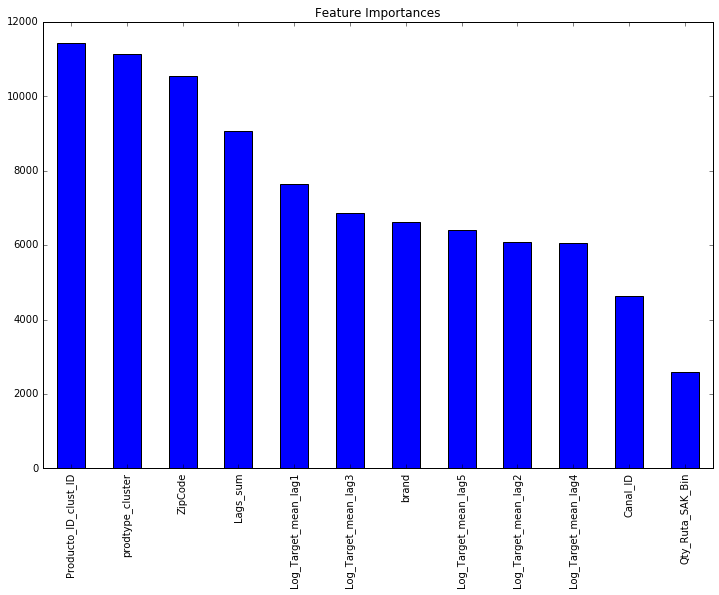

In [60]:
predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 
              'Log_Target_mean_lag5','Lags_sum', 'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'Producto_ID_clust_ID']

model = xgb.XGBRegressor(n_estimators = 300, objective="reg:linear", learning_rate= 0.1, max_depth=10,
                         subsample=0.85,colsample_bytree=0.7)

tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg11.csv')
tac()

feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

We improved a little bit as expected.